# <center> <u> GRU - Rolling Prediction

In [202]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv

load_dotenv()

db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [203]:
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

In [204]:
query="""
    select * 
    from agg.tidy_data_30min
    where site = 64
"""

In [205]:
df = pd.read_sql_query(query, conn)

/var/folders/n_/s_vk866s6ds93jqhjv__r6cr0000gn/T/ipykernel_26898/1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [206]:
df = df[['timestamp','net_load']]

In [207]:
df.rename(columns={'timestamp':'ts'},inplace=True)
df['ts'] = pd.to_datetime(df['ts'])
df.set_index('ts', inplace=True)
df.sort_index(inplace=True)
df

,net_load
ts,
2019-04-01 00:00:00+00:00,14.620
2019-04-01 00:30:00+00:00,16.700
2019-04-01 01:00:00+00:00,20.270
2019-04-01 01:30:00+00:00,15.870
2019-04-01 02:00:00+00:00,15.120
...,...
2020-03-31 20:30:00+00:00,14.390
2020-03-31 21:00:00+00:00,14.710
2020-03-31 21:30:00+00:00,14.950


## Normalise the Data

<Axes: xlabel='ts'>

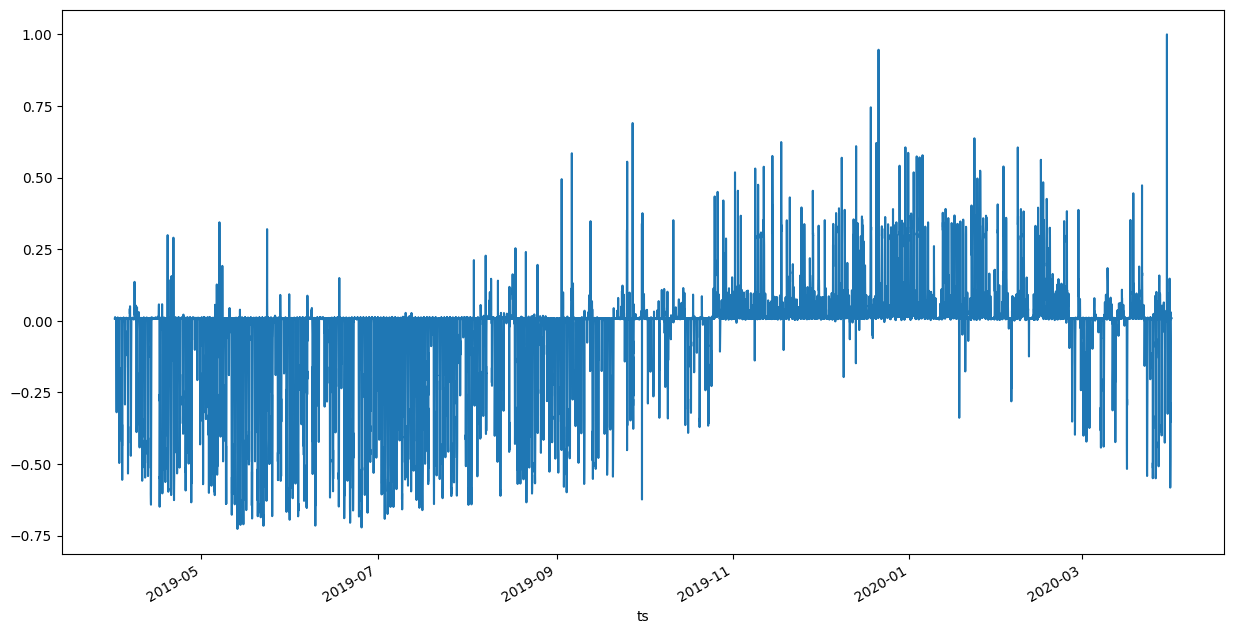

In [208]:
df['net_load_norm'] = df['net_load'] / max(abs(df['net_load']))
df.drop('net_load',axis=1,inplace=True)

plt.figure(figsize=(15,8))
df['net_load_norm'].plot()

## Create the Lags and Prepare Data for GRU Model

In [209]:
lags = [1, 2, 48, 96]
for lag in lags:
    df[f'lag_{lag}'] = df['net_load_norm'].shift(lag)

In [210]:
df.dropna(inplace=True)

In [211]:
X = df[['lag_1', 'lag_2', 'lag_48', 'lag_96']].values
y = df['net_load_norm'].values

In [212]:
X_train, X_test = X[:-72], X[-72:]
y_train, y_test = y[:-72], y[-72:]

In [213]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import InputLayer, GRU, BatchNormalization, Dense
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError
from keras.metrics import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error

In [214]:
model = Sequential()
model.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(8))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

/Users/adriachimenos/anaconda3/envs/aml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [215]:
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - loss: 0.0078
Epoch 2/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0043
Epoch 3/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 26s 49ms/step - loss: 0.0042
Epoch 4/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0039
Epoch 5/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - loss: 0.0039
Epoch 6/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0038
Epoch 7/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - loss: 0.0037
Epoch 8/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - loss: 0.0040
Epoch 9/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - loss: 0.0038
Epoch 10/10
543/543 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - loss: 0.0038


In [216]:
def get_input(ts, lags):
    # Convert lags to positions from the end of the series
    positions = [-1 - lag for lag in lags]
    # Use numpy indexing to get values at positions
    return ts[positions].reshape(1,len(lags),1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━

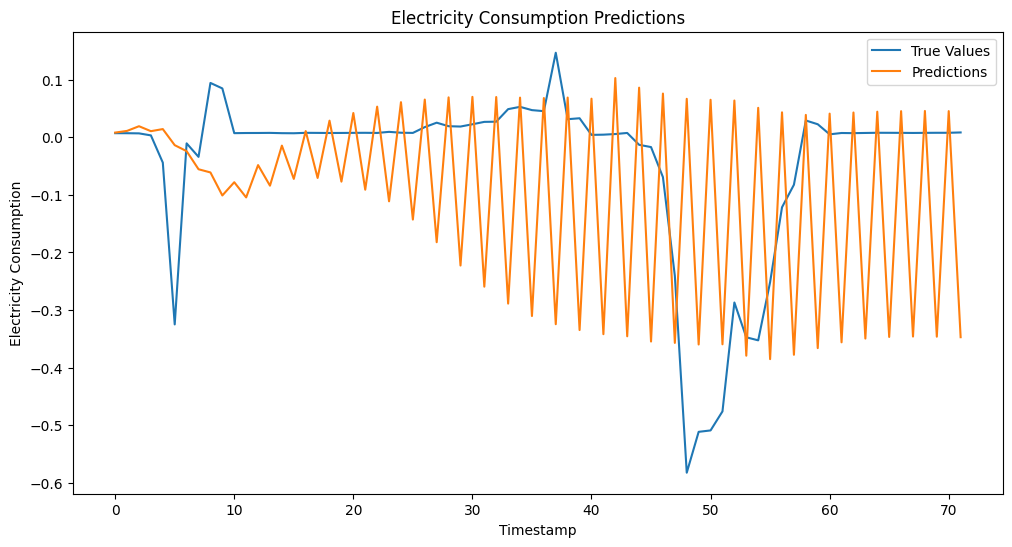

In [217]:
predictions = []
ts = y_train.copy()

# Iterate over each timestamp in the test set
for i in range(len(X_test)):
    x_input = get_input(ts,lags)
    pred_value = model.predict(x_input)
    ts=np.append(ts,pred_value)
    # Store the prediction
    predictions.append(pred_value)

# Convert the list of predictions to numpy array
predictions = np.array(predictions)

# Reshape the predictions array if needed
predictions = predictions.reshape(predictions.shape[0], 1)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Values')
plt.plot(predictions, label='Predictions')
plt.xlabel('Timestamp')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption Predictions')
plt.legend()
plt.show()

timeseries
hacer que el test dataset sean los ultimos 30 dias. hacer append de los originales despues de 36 horas y repetir el proceso.

Predecir con la funcion de arriba para 36 horas, y despues añadir.

## Improved Model 2

In [223]:
model2 = Sequential()
model2.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model2.add(GRU(32, activation='relu'))
model2.add(Dense(8))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')

ValueError: Input 0 of layer "gru_17" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 64)

In [ ]:
model2.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

## Improved Model 3

In [ ]:
model3 = Sequential()
model3.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model3.add(Dense(8))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mse')

In [ ]:
model3.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

## Improved Model 4

In [ ]:
model4 = Sequential()
model4.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model4.add(GRU(64, activation='relu', input_shape=(X_train.shape[1], 1)))
model4.add(Dropout(0.2))
model4.add(GRU(32, activation='relu', input_shape=(X_train.shape[1], 1)))
model4.add(Dense(8))
model4.add(Dense(1))
model4.compile(optimizer='adam', loss='mse')

In [ ]:
model4.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)